# Animating Other Body Models With AMASS
In the basic [AMASS visualization notebook](01-AMASS_Visualization.ipynb), we presented code snippets to animate AMASS bodies
with [SMPL+H](http://mano.is.tue.mpg.de/) body model.
However, we can use AMASS to also animate other SMPL family body models; namely:
- Body only [SMPL](https://smpl.is.tue.mpg.de/)
- Hand only [MANO](http://mano.is.tue.mpg.de/)
- Expressive  Body, with Hands and Face [SMPL-X](https://smpl-x.is.tue.mpg.de/).

AMASS uses [human_body_prior](https://github.com/nghorbani/human_body_prior) python package to animate bodies.
The provided body model interface handles all SMPL body family models automatically and transparently.
That means you can pass a SMPL family model to the BodyModel class and in the forward call pass desired body parameters from AMASS;
e.g. load an instance of SMPL and only pass pose_body that won't articulate fingers.
The rest will be taken care of automatically by the code.
This tutorial shows a practical example to animate SMPL and SMPL-X bodies using AMASS.

In [1]:
# Preparing the environment
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

In [2]:
from ipywidgets import interact_manual
from ipywidgets import IntSlider


import torch
import numpy as np

from human_body_prior.tools.omni_tools import copy2cpu as c2c
from os import path as osp



In [3]:
# Choose the device to run the body model on.
comp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
amass_npz_fname = osp.join(support_dir, 'github_data/amass_sample.npz') # the path to body data
bdata = np.load(amass_npz_fname)

num_betas = 16 # number of body parameters
num_dmpls = 8 # number of DMPL parameters

# you can set the gender manually and if it differs from data's then contact or interpenetration issues might happen
subject_gender = bdata['gender']

print('Data keys available:%s'%list(bdata.keys()))

print('The subject of the mocap sequence is  {}.'.format(subject_gender))

NameError: name 'osp' is not defined

In [5]:
time_length = len(bdata['trans'])

body_parms = {
    'root_orient': torch.Tensor(bdata['poses'][:, :3]).to(comp_device), # controls the global root orientation
    'pose_body': torch.Tensor(bdata['poses'][:, 3:66]).to(comp_device), # controls the body
    'pose_hand': torch.Tensor(bdata['poses'][:, 66:]).to(comp_device), # controls the finger articulation
    'trans': torch.Tensor(bdata['trans']).to(comp_device), # controls the global body position
    'betas': torch.Tensor(np.repeat(bdata['betas'][:num_betas][np.newaxis], repeats=time_length, axis=0)).to(comp_device), # controls the body shape. Body shape is static
    'dmpls': torch.Tensor(bdata['dmpls'][:, :num_dmpls]).to(comp_device) # controls soft tissue dynamics
}

print('Body parameter vector shapes: \n{}'.format(' \n'.join(['{}: {}'.format(k,v.shape) for k,v in body_parms.items()])))
print('time_length = {}'.format(time_length))

Body parameter vector shapes: 
root_orient: torch.Size([601, 3]) 
pose_body: torch.Size([601, 63]) 
pose_hand: torch.Size([601, 90]) 
trans: torch.Size([601, 3]) 
betas: torch.Size([601, 16]) 
dmpls: torch.Size([601, 8])
time_length = 601


In [6]:
import trimesh
from body_visualizer.tools.vis_tools import colors
from body_visualizer.mesh.mesh_viewer import MeshViewer
from body_visualizer.tools.vis_tools import show_image

imw, imh = 1600, 1600
mv = MeshViewer(width=imw, height=imh, use_offscreen=True)

## SMPL-X

## AMASS for SMPL
First download [SMPL](https://smpl.is.tue.mpg.de/) body model and extract it to a desired location.
The PCA shape space of SMPL and SMPL+H are compatible, so betas and DMPLs can be used interchangeably.
Of course SMPL model does not support hand articulation, unlike SMPL+H. Hence, we cannot animate fingers of SMPL using AMASS.

In [7]:
from human_body_prior.body_model.body_model import BodyModel

bm_smpl_fname = osp.join(support_dir, 'body_models/smpl/{}/model.npz'.format(subject_gender))
# bm_smpl_fname = '/is/ps3/nghorbani/code-repos/amass/support_data/body_models/smpl/neutral/model.npz'

bm = BodyModel(bm_fname=bm_smpl_fname, num_betas=num_betas).to(comp_device)

faces = c2c(bm.f)
num_verts = bm.init_v_template.shape[1]

{'pose_body': torch.Size([601, 63]), 'betas': torch.Size([601, 16])}


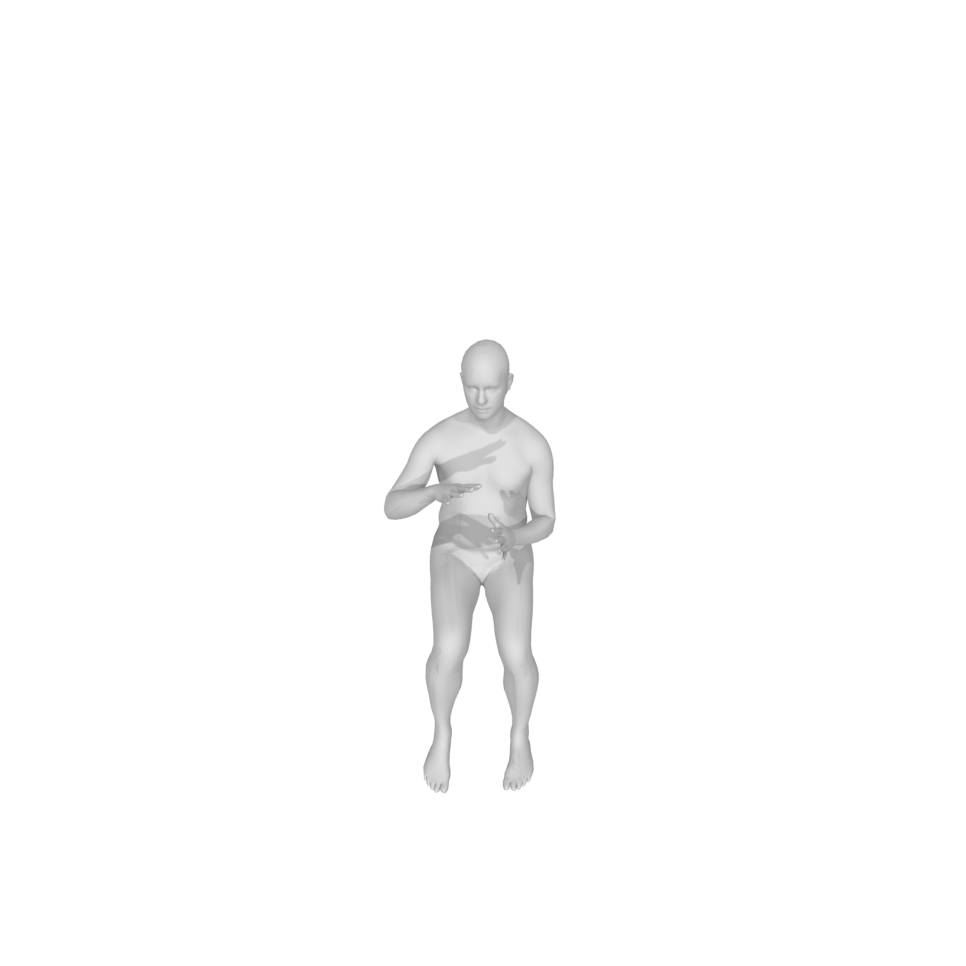

In [8]:
print({k:v.shape for k,v in body_parms.items() if k in ['pose_body', 'betas']})
body = bm(**{k:v.to(comp_device) for k,v in body_parms.items() if k in ['pose_body']})
body_mesh_wofingers = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (num_verts, 1)))
mv.set_static_meshes([body_mesh_wofingers])
body_image_wofingers = mv.render(render_wireframe=False)
show_image(body_image_wofingers)

Notice the flat hands due to inability of SMPL to articulate fingers. Due to this fact, we didn't pass pose_hand parameters neither.

## AMASS for SMPL-X
First obtain [SMPL-X](https://smpl-x.is.tue.mpg.de) body model and extract it at a desired location.
The PCA shape space of SMPL-X and SMPL+H do not correspond, so we cannot use the shape,
i.e. betas, nor the soft tissue dynamics, i.e. DMPLs, from AMASS on SMPL-X.
However,  we can still pose the body model using AMASS parameters.
SMPL-X has more joints than the SMPLH model because of the eye balls and jaw joints, hence we cannot animate jaw and eye balls using AMASS.

In [14]:
from human_body_prior.body_model.body_model import BodyModel
import torch
from ipywidgets import interact_manual
from ipywidgets import IntSlider


import torch
import numpy as np

from human_body_prior.tools.omni_tools import copy2cpu as c2c
from os import path as osp



comp_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bm_smplx_fname = "G:\\UAL_Thesis\\affective_computing_datasets\\smplx_lockedhead_20230207\\models_lockedhead\\smplx\\SMPLX_NEUTRAL.npz"
num_betas = 16 # number of body parameters
bm = BodyModel(bm_path=bm_smplx_fname, num_betas=num_betas, model_type="smplx").to(comp_device)

faces = c2c(bm.f)
num_verts = bm.v_template.shape[1]

In [36]:
amass_npz_fname = "G:\\UAL_Thesis\\affective_computing_datasets\\DanceDB_SMPLX\\DanceDB\\20120731_StefanosTheodorou\\Stefanos_1os_antrikos_karsilamas_C3D_stageii.npz"

bdata = np.load(amass_npz_fname)

time_length = len(bdata['trans'])

body_parms = {
    'root_orient': torch.Tensor(bdata['poses'][:, :3]).to(comp_device).view(time_length, -1),
    'pose_body': torch.Tensor(bdata['poses'][:, 3:66]).to(comp_device).view(time_length, -1),
    'pose_hand': torch.Tensor(bdata['poses'][:, 66:]).to(comp_device).view(time_length, -1),
    'trans': torch.Tensor(bdata['trans']).to(comp_device).view(time_length, -1),
    'betas': torch.Tensor(np.repeat(bdata['betas'][:num_betas][np.newaxis], repeats=time_length, axis=0)).to(comp_device).view(time_length, -1),
    # 'dmpls': torch.Tensor(bdata['dmpls'][:, :num_dmpls]).to(comp_device).view(time_length, -1)
}

# Ensure all tensors have the same first dimension
assert all(p.shape[0] == time_length for p in body_parms.values()), "All body parameters should have the same number of frames."

# Forward pass through the model for each frame
for i in range(time_length):
    body = bm(**{k: v[i].unsqueeze(0) for k, v in body_parms.items() if k in ['root_orient', 'pose_body', 'pose_hand', 'trans', 'betas']})
    body_mesh_wfingers = trimesh.Trimesh(vertices=c2c(body.v[0]), faces=faces, vertex_colors=np.tile(colors['grey'], (num_verts, 1)))
    mv.set_static_meshes([body_mesh_wfingers])
    body_image_wfingers = mv.render(render_wireframe=False)
    show_image(body_image_wfingers)

TypeError: lbs() got an unexpected keyword argument 'dtype'

: 

In [23]:
import numpy as np

# Path to the AMASS dataset file (adjust this to your file's location)
amass_file_path = amass_npz_fname 

# Load the AMASS dataset
data = np.load(amass_file_path)

# The exact key for keypoints might vary depending on the dataset version and structure
# Common keys might be 'poses', 'joints', 'keypoints', etc.
# You might need to check the available keys in your dataset and choose the correct one
print("Available keys in the dataset:", data.files)

# Assuming the keypoints are stored under the key 'poses'
keypoints = data['poses']

# Now 'keypoints' variable holds the skeleton data
# You can process or visualize it as needed
print("Shape of keypoints:", keypoints.shape)


Available keys in the dataset: ['gender', 'surface_model_type', 'mocap_frame_rate', 'mocap_time_length', 'markers_latent', 'latent_labels', 'markers_latent_vids', 'trans', 'poses', 'betas', 'num_betas', 'root_orient', 'pose_body', 'pose_hand', 'pose_jaw', 'pose_eye', 'markers', 'labels', 'markers_obs', 'labels_obs', 'markers_sim', 'marker_meta', 'num_markers']
Shape of keypoints: (10102, 165)


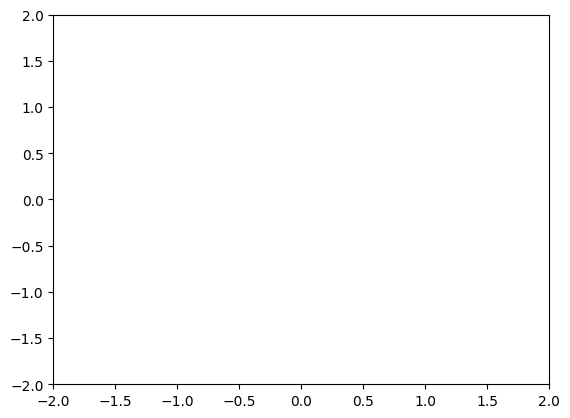

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Load your data here
# For example: keypoints = np.load('path_to_your_data.npz')['poses']

# Define the connections between joints to create the skeleton
# This depends on how your keypoints are structured
skeleton = [
    (0, 1), (1, 2), (2, 3), (3, 4),  # Spine and head
    (0, 5), (5, 6), (6, 7), (7, 8),  # Left leg
    (0, 9), (9, 10), (10, 11), (11, 12),  # Right leg
    (4, 13), (13, 14), (14, 15),  # Left arm
    (4, 16), (16, 17), (17, 18),  # Right arm
    (15, 19), (15, 20), (15, 21),  # Left hand
    (18, 22), (18, 23), (18, 24),  # Right hand
    (15, 25), (15, 26), (15, 27),  # Left fingers
    (18, 28), (18, 29), (18, 30),  # Right fingers
    (15, 31), (15, 32), (15, 33),  # Left toes
    (18, 34), (18, 35), (18, 36),  # Right toes
    (4, 37), (37, 38), (38, 39),  # Neck and jaw
    (39, 40), (39, 41),  # Eyes
    (4, 42), (42, 43), (43, 44),  # Left shoulder and elbow
    (4, 45), (45, 46), (46, 47),  # Right shoulder and elbow
    (44, 48), (44, 49), (44, 50),  # Left wrist and fingers
    (47, 51), (47, 52), (47, 53),  # Right wrist and fingers
]


# Create a function to update the plot for each frame
def update(num, keypoints, lines):
    for i, line in enumerate(lines):
        # For 3D data, you might want to project to 2D
        line.set_data(keypoints[num, skeleton[i], :2].T)
        print(keypoints)

    return lines


# Set up the plot
fig, ax = plt.subplots()
lines = [plt.plot([], [], 'ro-')[0] for _ in range(len(skeleton))]
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(keypoints), fargs=(keypoints, lines), interval=50)

plt.show()


In [33]:
import cv2
import numpy as np
from tqdm import tqdm

def draw_skeleton(frame, keypoints, connections, color=(0, 255, 0), circle_radius=5, line_thickness=2):
    h, w, _ = frame.shape
    for joint in keypoints:
        x, y, _ = joint
        x_unnormalized = int((x + 1) / 2 * w)
        y_unnormalized = int((y + 1) / 2 * h)
        cv2.circle(frame, (x_unnormalized, y_unnormalized), circle_radius, color, -1)
    
    for connection in connections:
        joint_start, joint_end = connection
        x_start, y_start, _ = keypoints[joint_start]
        x_end, y_end, _ = keypoints[joint_end]
        x_start_unnormalized = int((x_start + 1) / 2 * w)
        y_start_unnormalized = int((y_start + 1) / 2 * h)
        x_end_unnormalized = int((x_end + 1) / 2 * w)
        y_end_unnormalized = int((y_end + 1) / 2 * h)
        cv2.line(frame, (x_start_unnormalized, y_start_unnormalized), (x_end_unnormalized, y_end_unnormalized), color, line_thickness)


# Define the connections between joints based on the SMPL-X model
connections = [
    (0, 1), (1, 2), (2, 3), (3, 4),  # Spine and head
    (0, 5), (5, 6), (6, 7), (7, 8),  # Left leg
    (0, 9), (9, 10), (10, 11), (11, 12),  # Right leg
    (4, 13), (13, 14), (14, 15),  # Left arm
    (4, 16), (16, 17), (17, 18),  # Right arm
    (15, 19), (15, 20), (15, 21),  # Left hand
    (18, 22), (18, 23), (18, 24),  # Right hand
    (15, 25), (15, 26), (15, 27),  # Left fingers
    (18, 28), (18, 29), (18, 30),  # Right fingers
    (15, 31), (15, 32), (15, 33),  # Left toes
    (18, 34), (18, 35), (18, 36),  # Right toes
    (4, 37), (37, 38), (38, 39),  # Neck and jaw
    (39, 40), (39, 41),  # Eyes
    (4, 42), (42, 43), (43, 44),  # Left shoulder and elbow
    (4, 45), (45, 46), (46, 47),  # Right shoulder and elbow
    (44, 48), (44, 49), (44, 50),  # Left wrist and fingers
    (47, 51), (47, 52), (47, 53),  # Right wrist and fingers
]


num_frames = keypoints.shape[0]
height, width = 720, 1280  # Set the height and width of the output video

# Create a VideoCapture object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (width, height))

for i in tqdm(range(num_frames)):
    frame = np.zeros((height, width, 3), dtype=np.uint8)
    draw_skeleton(frame, keypoints[i].reshape(-1, 3), connections)  # Reshape keypoints for each frame
    out.write(frame)
    cv2.imshow('Skeleton', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

out.release()
cv2.destroyAllWindows()


 63%|██████▎   | 6375/10102 [01:23<00:48, 76.42it/s] 


KeyboardInterrupt: 

In [34]:
import cv2
import numpy as np
from tqdm import tqdm

def rotate_points(points, angle):
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]
    ])
    return points.dot(rotation_matrix.T)

def draw_skeleton(frame, keypoints, connections, color=(0, 255, 0), circle_radius=5, line_thickness=2):
    h, w, _ = frame.shape
    angle = np.pi  # Rotate 180 degrees to view from front
    keypoints_rotated = rotate_points(keypoints, angle)
    
    for joint in keypoints_rotated:
        x, y, _ = joint
        x_unnormalized = int((x + 1) / 2 * w)
        y_unnormalized = int((y + 1) / 2 * h)
        cv2.circle(frame, (x_unnormalized, y_unnormalized), circle_radius, color, -1)
    
    for connection in connections:
        joint_start, joint_end = connection
        x_start, y_start, _ = keypoints_rotated[joint_start]
        x_end, y_end, _ = keypoints_rotated[joint_end]
        x_start_unnormalized = int((x_start + 1) / 2 * w)
        y_start_unnormalized = int((y_start + 1) / 2 * h)
        x_end_unnormalized = int((x_end + 1) / 2 * w)
        y_end_unnormalized = int((y_end + 1) / 2 * h)
        cv2.line(frame, (x_start_unnormalized, y_start_unnormalized), (x_end_unnormalized, y_end_unnormalized), color, line_thickness)

# Define the connections between joints based on the SMPL-X model
connections = [
    (0, 1), (1, 2), (2, 3), (3, 4),  # Spine and head
    (0, 5), (5, 6), (6, 7), (7, 8),  # Left leg
    (0, 9), (9, 10), (10, 11), (11, 12),  # Right leg
    (4, 13), (13, 14), (14, 15),  # Left arm
    (4, 16), (16, 17), (17, 18),  # Right arm
    (15, 19), (15, 20), (15, 21),  # Left hand
    (18, 22), (18, 23), (18, 24),  # Right hand
    (15, 25), (15, 26), (15, 27),  # Left fingers
    (18, 28), (18, 29), (18, 30),  # Right fingers
    (15, 31), (15, 32), (15, 33),  # Left toes
    (18, 34), (18, 35), (18, 36),  # Right toes
    (4, 37), (37, 38), (38, 39),  # Neck and jaw
    (39, 40), (39, 41),  # Eyes
    (4, 42), (42, 43), (43, 44),  # Left shoulder and elbow
    (4, 45), (45, 46), (46, 47),  # Right shoulder and elbow
    (44, 48), (44, 49), (44, 50),  # Left wrist and fingers
    (47, 51), (47, 52), (47, 53),  # Right wrist and fingers
]


num_frames = keypoints.shape[0]
height, width = 720, 1280  # Set the height and width of the output video

# Create a VideoCapture object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (width, height))

for i in tqdm(range(num_frames)):
    frame = np.zeros((height, width, 3), dtype=np.uint8)
    draw_skeleton(frame, keypoints[i].reshape(-1, 3), connections)  # Reshape keypoints for each frame
    out.write(frame)
    cv2.imshow('Skeleton', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

out.release()
cv2.destroyAllWindows()


 40%|████      | 4089/10102 [00:55<01:21, 74.05it/s] 


KeyboardInterrupt: 

In [35]:
import numpy as np
import cv2

def draw_skeleton(frame, keypoints, connections, color=(0, 255, 0), circle_radius=5, line_thickness=2):
    h, w, _ = frame.shape
    for joint in keypoints:
        x, y, _ = joint
        x_unnormalized = int((x + 1) / 2 * w)
        y_unnormalized = int((y + 1) / 2 * h)
        cv2.circle(frame, (x_unnormalized, y_unnormalized), circle_radius, color, -1)
    
    for connection in connections:
        joint_start, joint_end = connection
        x_start, y_start, _ = keypoints[joint_start]
        x_end, y_end, _ = keypoints[joint_end]
        x_start_unnormalized = int((x_start + 1) / 2 * w)
        y_start_unnormalized = int((y_start + 1) / 2 * h)
        x_end_unnormalized = int((x_end + 1) / 2 * w)
        y_end_unnormalized = int((y_end + 1) / 2 * h)
        cv2.line(frame, (x_start_unnormalized, y_start_unnormalized), (x_end_unnormalized, y_end_unnormalized), color, line_thickness)

# Load the SMPL-X npz file
npz_filename = amass_npz_fname
data = np.load(npz_filename)

# Extract keypoints (joints)
keypoints = data['keypoints']  # Replace 'keypoints' with the actual key in your npz file

# Define connections based on SMPL-X model (you might need to adjust this based on your model)
connections = [
    (0, 1), (1, 2), (2, 3), (3, 4),  # Spine and head
    (0, 5), (5, 6), (6, 7), (7, 8),  # Left leg
    (0, 9), (9, 10), (10, 11), (11, 12),  # Right leg
    (4, 13), (13, 14), (14, 15),  # Left arm
    (4, 16), (16, 17), (17, 18),  # Right arm
    (15, 19), (15, 20), (15, 21),  # Left hand
    (18, 22), (18, 23), (18, 24),  # Right hand
    (15, 25), (15, 26), (15, 27),  # Left fingers
    (18, 28), (18, 29), (18, 30),  # Right fingers
    (15, 31), (15, 32), (15, 33),  # Left toes
    (18, 34), (18, 35), (18, 36),  # Right toes
    (4, 37), (37, 38), (38, 39),  # Neck and jaw
    (39, 40), (39, 41),  # Eyes
    (4, 42), (42, 43), (43, 44),  # Left shoulder and elbow
    (4, 45), (45, 46), (46, 47),  # Right shoulder and elbow
    (44, 48), (44, 49), (44, 50),  # Left wrist and fingers
    (47, 51), (47, 52), (47, 53),  # Right wrist and fingers
]

# Create a video to visualize the skeleton
num_frames = keypoints.shape[0]
height, width = 720, 1280
out = cv2.VideoWriter('output.avi', cv2.VideoWriter_fourcc(*'XVID'), 20.0, (width, height))

for i in range(num_frames):
    frame = np.zeros((height, width, 3), dtype=np.uint8)
    draw_skeleton(frame, keypoints[i].reshape(-1, 3), connections)
    out.write(frame)
    cv2.imshow('Skeleton', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

out.release()
cv2.destroyAllWindows()


KeyError: 'keypoints is not a file in the archive'

In [32]:
keypoints[0]

array([ 1.19092072e+00, -1.00347575e+00, -1.18668399e+00,  2.00684487e-01,
        4.94870142e-02,  3.86226348e-02,  1.94893044e-01, -1.13796658e-01,
       -3.35413169e-03,  5.78381430e-02,  5.05995573e-02,  2.15738147e-02,
       -2.08302147e-01, -2.67837238e-01,  3.97589680e-02, -1.02878405e-01,
        1.63699730e-01,  7.17834491e-02,  3.38586784e-02, -5.16442601e-02,
       -3.77532168e-02, -1.65941065e-01,  3.32185123e-01, -4.40265163e-02,
       -1.84721514e-01, -4.01111442e-01,  2.39762189e-01,  9.76937245e-02,
        2.56143181e-02, -1.63103162e-04,  1.51768857e-02,  2.62254375e-04,
        1.02288294e-01,  6.02885732e-02,  2.93955070e-01, -3.39801716e-01,
        1.14735033e-01,  9.78907901e-02, -6.88231490e-04, -2.26184435e-01,
       -5.33848071e-02,  1.63124640e-01, -1.81265659e-01,  5.48554499e-02,
       -1.31056565e-01,  9.54507973e-02, -8.89299729e-03,  3.27106055e-02,
       -2.82672340e-01, -1.96786510e-01,  2.95397020e-02, -2.30212793e-01,
        7.03937559e-02,  

In [28]:
print(keypoints.shape)

(10102, 165)


You won't see a perfect match with original SMPL+H body because the shape is not taken into account with the above body.
SMPL+H and SMPLx body parameters are not fully compatible.
For next releases of AMASS we intend to include more model types from SMPL family.